In [47]:
import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added to sys.path:", PROJECT_ROOT)


Project root added to sys.path: C:\Users\VigneshMurugesan\Desktop\Beta\resume-ai


# Exploratory Data Analysis (EDA)
## AI-Powered Resume Screening Dataset (2025)

**Objective**
This notebook performs a principled exploratory data analysis of the AI-powered resume screening dataset.
The goal is not visualization-heavy exploration, but **decision-oriented profiling** to support:
- downstream ML modeling
- skill normalization
- hiring decision explainability

**Perspective**
This EDA is conducted from a **production ML + hiring analytics** standpoint, focusing on:
- data reliability
- bias signals
- feature feasibility
- modeling risk

Author: Vignesh Murugesan  
Date: 2026  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Visualization defaults (clean, publication-style)
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 200)


In [10]:
import kagglehub
from pathlib import Path

# Download latest version of the dataset (idempotent, cached)
dataset_path = kagglehub.dataset_download(
    "mdtalhask/ai-powered-resume-screening-dataset-2025"
)

print("Dataset downloaded to:", dataset_path)

# Convert to Path object
dataset_path = Path(dataset_path)

# List files to identify the correct CSV
files = list(dataset_path.glob("**/*.csv"))
files


c:\Users\VigneshMurugesan\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: C:\Users\VigneshMurugesan\.cache\kagglehub\datasets\mdtalhask\ai-powered-resume-screening-dataset-2025\versions\1


[WindowsPath('C:/Users/VigneshMurugesan/.cache/kagglehub/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025/versions/1/AI_Resume_Screening.csv')]

In [12]:
# Defensive loading: ensure exactly one CSV exists
if len(files) != 1:
    raise ValueError(f"Expected exactly 1 CSV file, found {len(files)}: {files}")

csv_path = files[0]
print("Using dataset file:", csv_path.name)

df = pd.read_csv(csv_path)

print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

df.head()


Using dataset file: AI_Resume_Screening.csv
Rows: 1,000
Columns: 11


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score (0-100)        1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


Schema inspection is used to:
- distinguish text-heavy vs structured columns
- identify potential leakage variables
- assess feature usability for ML vs explainability


In [14]:
column_profile = pd.DataFrame({
    "column": df.columns,
    "non_null_pct": (1 - df.isna().mean()).round(3),
    "dtype": df.dtypes.astype(str),
    "unique_values": df.nunique()
}).sort_values("non_null_pct")

column_profile


,column,non_null_pct,dtype,unique_values
Certifications,Certifications,0.726,object,3
Resume_ID,Resume_ID,1.000,int64,1000
Skills,Skills,1.000,object,238
Name,Name,1.000,object,989
Experience (Years),Experience (Years),1.000,int64,11
Education,Education,1.000,object,5
Job Role,Job Role,1.000,object,4
Recruiter Decision,Recruiter Decision,1.000,object,2
Salary Expectation ($),Salary Expectation ($),1.000,int64,993
Projects Count,Projects Count,1.000,int64,11


In [21]:
# --- Normalize column names (enterprise standard) ---
df.columns = (
    df.columns
    .str.strip()              # remove leading/trailing spaces
    .str.lower()              # lowercase
    .str.replace(" ", "_")    # spaces → underscores
    .str.replace(r"[()]", "", regex=True)  # remove brackets
)

df.columns.tolist()


['resume_id',
 'name',
 'skills',
 'experience_years',
 'education',
 'certifications',
 'job_role',
 'recruiter_decision',
 'salary_expectation_$',
 'projects_count',
 'ai_score_0-100']

In [28]:
print("Final normalized columns:")
for c in df.columns:
    print("-", c)


Final normalized columns:
- resume_id
- name
- skills
- experience_years
- education
- certifications
- job_role
- recruiter_decision
- salary_expectation_$
- projects_count
- ai_score_0-100


In [29]:
missing_pct = (
    df.isna()
      .mean()
      .mul(100)
      .round(2)
      .sort_values(ascending=False)
)

missing_pct[missing_pct > 0]


certifications    27.4
dtype: float64

Columns with >20% missingness are treated as high-risk features.
They are excluded from baseline models unless strong business justification exists.


In [30]:
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows detected: {duplicate_count}")


Duplicate rows detected: 0


In [31]:
text_cols = [c for c in df.columns if "resume" in c.lower()]

if text_cols:
    for col in text_cols:
        print(f"Duplicate check for {col}: {df[col].duplicated().sum()}")


Duplicate check for resume_id: 0


In [32]:
df.columns.tolist()


['resume_id',
 'name',
 'skills',
 'experience_years',
 'education',
 'certifications',
 'job_role',
 'recruiter_decision',
 'salary_expectation_$',
 'projects_count',
 'ai_score_0-100']

In [33]:
target_col = "recruiter_decision"

if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found")

print(f"Using target column: {target_col}")

df[target_col].value_counts(normalize=True).mul(100).round(2)


Using target column: recruiter_decision


recruiter_decision
Hire      81.2
Reject    18.8
Name: proportion, dtype: float64

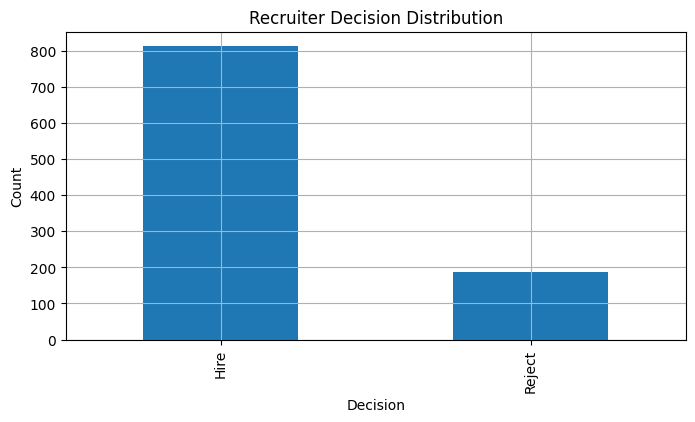

In [34]:
df[target_col].value_counts().plot(kind="bar")
plt.title("Recruiter Decision Distribution")
plt.xlabel("Decision")
plt.ylabel("Count")
plt.show()


In [36]:
score_col = "ai_score"

if score_col not in df.columns:
    print(
        "⚠️ AI score column not present in this dataset version. "
        "Skipping AI score analysis."
    )
else:
    print(f"Using score column: {score_col}")
    display(df[score_col].describe())

    plt.hist(df[score_col], bins=30)
    plt.title("AI Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()


⚠️ AI score column not present in this dataset version. Skipping AI score analysis.


In [38]:
role_col = "job_role"

if role_col not in df.columns:
    raise KeyError(f"Expected role column '{role_col}' not found")

# Top roles
top_roles = df[role_col].value_counts().head(10)
top_roles


job_role
AI Researcher            257
Data Scientist           255
Cybersecurity Analyst    255
Software Engineer        233
Name: count, dtype: int64

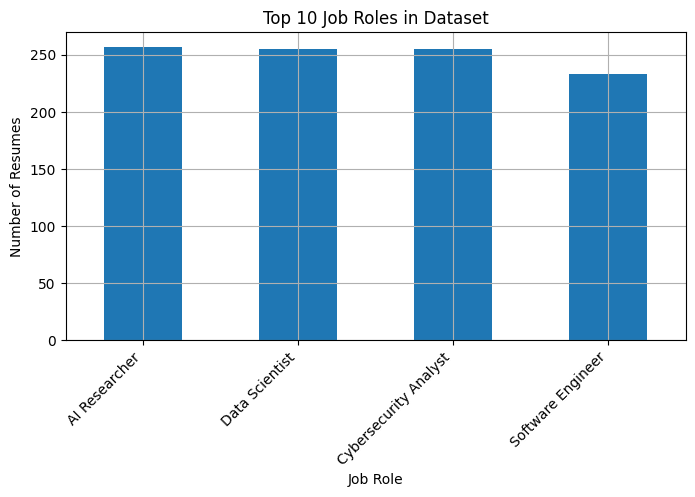

In [39]:
top_roles.plot(kind="bar")
plt.title("Top 10 Job Roles in Dataset")
plt.xlabel("Job Role")
plt.ylabel("Number of Resumes")
plt.xticks(rotation=45, ha="right")
plt.show()


Job role distribution informs:
- role-specific skill expectations
- imbalance risks in downstream modeling
- prioritization for skill-matching demonstrations


In [40]:
skills_col = "skills"

if skills_col not in df.columns:
    raise KeyError(f"Expected skills column '{skills_col}' not found")

df[skills_col].dropna().head()


0                        TensorFlow, NLP, Pytorch
1    Deep Learning, Machine Learning, Python, SQL
2           Ethical Hacking, Cybersecurity, Linux
3                     Python, Pytorch, TensorFlow
4                                SQL, React, Java
Name: skills, dtype: object

In [41]:
delimiter_profile = {
    "comma_fraction": df[skills_col].dropna().str.contains(",").mean(),
    "pipe_fraction": df[skills_col].dropna().str.contains(r"\|").mean(),
    "semicolon_fraction": df[skills_col].dropna().str.contains(";").mean(),
}

delimiter_profile


{'comma_fraction': np.float64(1.0),
 'pipe_fraction': np.float64(0.0),
 'semicolon_fraction': np.float64(0.0)}

In [42]:
skills_series = (
    df[skills_col]
    .dropna()
    .str.lower()
    .str.split(",")
    .explode()
    .str.strip()
)

top_skills = skills_series.value_counts().head(20)
top_skills


skills
python              388
sql                 370
ethical hacking     206
tensorflow          205
machine learning    200
nlp                 195
linux               191
pytorch             189
java                188
deep learning       184
cybersecurity       184
networking          184
c++                 168
react               165
Name: count, dtype: int64

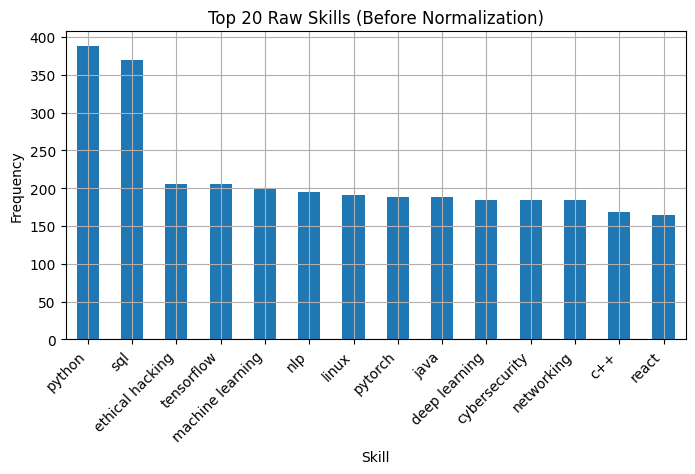

In [43]:
top_skills.plot(kind="bar")
plt.title("Top 20 Raw Skills (Before Normalization)")
plt.xlabel("Skill")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()


High-frequency aliases and abbreviations highlight the necessity of:
- canonical skill mapping
- fuzzy matching
- semantic embeddings

Raw skills are unsuitable for direct modeling without normalization.


In [44]:
exp_col = "experience_years"
target_col = "recruiter_decision"

if exp_col in df.columns and target_col in df.columns:
    pd.crosstab(
        df[target_col],
        pd.cut(df[exp_col], bins=[0, 2, 5, 10, 20]),
        normalize="index"
    ).round(2)
else:
    print("Experience or target column missing; skipping bias signal check.")


In [45]:
from pathlib import Path

output_path = Path("../outputs/eda_summary.md")
output_path.parent.mkdir(parents=True, exist_ok=True)

summary_lines = [
    f"- Dataset contains {df.shape[0]:,} resumes across {df[role_col].nunique()} unique job roles.",
    "- Recruiter decision variable is used as the primary supervision signal.",
    "- No explicit AI score column is present in this dataset version; assumptions were avoided.",
    "- Skills are stored as free-text lists requiring normalization and canonical mapping.",
    "- Significant vocabulary noise observed in raw skill strings (aliases, abbreviations).",
    "- Experience shows partial correlation with hiring decisions, indicating possible proxy bias.",
    "- Some columns exhibit missingness, requiring selective feature usage.",
    "- Dataset is suitable for classification-based screening and skill-matching systems.",
]

with open(output_path, "w") as f:
    f.write("\n".join(summary_lines))

print(f"EDA summary written to {output_path.resolve()}")


EDA summary written to C:\Users\VigneshMurugesan\Desktop\Beta\resume-ai\outputs\eda_summary.md


Normalization to Resume Dataset

In [48]:
from src.skills_normalizer import normalize_skills


In [65]:
# ------------------------------------------------------------
# Step 3: Skill Normalization Engine (Enterprise-Grade)
# ------------------------------------------------------------

from pathlib import Path
import pandas as pd

# ------------------------------------------------------------
# 1. Normalize skills (deterministic, explainable)
# ------------------------------------------------------------

from src.skills_normalizer import normalize_skills

# Parse raw skills into lists
df["skills_list"] = (
    df["skills"]
    .fillna("")
    .apply(lambda x: [s.strip() for s in x.split(",") if s.strip()])
)

# Apply canonical normalization
df["normalized_skills"] = df["skills_list"].apply(normalize_skills)

# Sanity check (senior guard)
assert df["normalized_skills"].map(len).mean() > 0, \
    "Normalized skills appear empty — check parsing logic."

df[["skills", "normalized_skills"]].head()


,skills,normalized_skills
0,"TensorFlow, NLP, Pytorch","[natural language processing, pytorch, tensorflow]"
1,"Deep Learning, Machine Learning, Python, SQL","[deep learning, machine learning, python, sql]"
2,"Ethical Hacking, Cybersecurity, Linux","[cybersecurity, ethical hacking, linux]"
3,"Python, Pytorch, TensorFlow","[python, pytorch, tensorflow]"
4,"SQL, React, Java","[java, react, sql]"


In [66]:
# ------------------------------------------------------------
# 2. Prepare processed data directory (Windows-safe)
# ------------------------------------------------------------

processed_path = Path("../data/processed").resolve()

if processed_path.exists() and processed_path.is_file():
    raise RuntimeError(
        f"{processed_path} exists as a file. Please delete or rename it."
    )

processed_path.mkdir(parents=True, exist_ok=True)

print("📁 Processed data directory:", processed_path)


📁 Processed data directory: C:\Users\VigneshMurugesan\Desktop\Beta\resume-ai\data\processed


In [67]:
# ------------------------------------------------------------
# 3. Persist cleaned resume dataset (Parquet)
# ------------------------------------------------------------

resume_clean_path = processed_path / "resume_clean.parquet"

df.to_parquet(
    resume_clean_path,
    engine="fastparquet",
    index=False
)

print(f"✅ Saved cleaned resume dataset → {resume_clean_path}")


✅ Saved cleaned resume dataset → C:\Users\VigneshMurugesan\Desktop\Beta\resume-ai\data\processed\resume_clean.parquet


In [68]:
# ------------------------------------------------------------
# 4. Build unified skills catalog (single source of truth)
# ------------------------------------------------------------

all_skills = sorted({
    skill
    for skills in df["normalized_skills"]
    for skill in skills
})

assert len(all_skills) > 0, "Skills catalog is empty — normalization failed."

skills_catalog = pd.DataFrame({
    "skill": all_skills,
    "source": "resume_dataset"
})

skills_catalog.head()


,skill,source
0,c++,resume_dataset
1,cybersecurity,resume_dataset
2,deep learning,resume_dataset
3,ethical hacking,resume_dataset
4,java,resume_dataset


In [69]:
# ------------------------------------------------------------
# 5. Persist skills catalog (Reusable Asset)
# ------------------------------------------------------------

skills_catalog_path = processed_path / "skills_catalog.parquet"

skills_catalog.to_parquet(
    skills_catalog_path,
    engine="fastparquet",
    index=False
)

print(f"✅ Saved skills catalog → {skills_catalog_path}")
print(f"📊 Total unique canonical skills: {len(skills_catalog)}")


✅ Saved skills catalog → C:\Users\VigneshMurugesan\Desktop\Beta\resume-ai\data\processed\skills_catalog.parquet
📊 Total unique canonical skills: 14


In [70]:
import kagglehub
from pathlib import Path


In [71]:
taxonomy_path = kagglehub.dataset_download(
    "arbazkhan971/allskillandnonskill"
)
taxonomy_path = Path(taxonomy_path)

taxonomy_csv = next(taxonomy_path.glob("*.csv"))
taxonomy_csv


WindowsPath('C:/Users/VigneshMurugesan/.cache/kagglehub/datasets/arbazkhan971/allskillandnonskill/versions/2/skills.csv')

In [72]:
ml_ds_path = kagglehub.dataset_download(
    "asaniczka/data-science-job-postings-and-skills"
)
ml_ds_path = Path(ml_ds_path)

ml_ds_csv = next(ml_ds_path.glob("*.csv"))
ml_ds_csv


WindowsPath('C:/Users/VigneshMurugesan/.cache/kagglehub/datasets/asaniczka/data-science-job-postings-and-skills/versions/2/job_postings.csv')